In [1]:
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
path = '/nfs/team283/aa16/KR_NAS/'
os.chdir(path)
sys.path.append(path)
from IPython.display import Image
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True' + ',dnn.enabled=False'
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import countcorrect as cc

Can not use cuDNN on context None: Disabled by dnn.enabled flag
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:89:00.0)


Load Data:

In [2]:
adata = sc.read_h5ad('/nfs/team283/aa16/KR_NAS/data/CR_cells_AnnData.h5ad')

Check what ROI types we have:

In [3]:
(adata.obs['Tissue'].astype(str) + ' ' + adata.obs['Pool'].astype(str)).value_counts()

Foetal brain (occipital lobe) CRcells     20
Foetal brain (occipital lobe) Residual    20
Foetal brain (temporal lobe) CRcells      20
Foetal brain (temporal lobe) Residual     19
Foetal brain (frontal lobe) CRcells       18
Foetal brain (frontal lobe) Residual      17
Foetal brain (parietal lobe) CRcells      16
Foetal brain (parietal lobe) Residual     14
Foetal brain (occipital lobe) Rings        1
dtype: int64

Remove Background with Naive Method and save in AnnData object:

In [4]:
counts_geneProbes = np.asarray(adata.X)
counts_negativeProbes = np.asarray(adata.obsm['negProbes'])
# Nuclei counts can be empty for naive method:
counts_nuclei = np.array(adata.obs['nuclei']).reshape(len(adata.obs['nuclei']))

In [5]:
adata.layers['X_corrected_naive'] = cc.run_countcorrect(counts_geneProbes, counts_negativeProbes, counts_nuclei, naive  = True)

In [6]:
total_counts = np.sum(adata.layers['X_corrected_naive'], axis = 1)
cpm = adata.layers['X_corrected_naive']/total_counts.reshape(np.shape(adata.layers['X_corrected_naive'])[0],1)*10**6
adata.layers['X_corrected_naive_cpm'] = cpm

Initializing model...
Fitting model ...


Finished [100%]: Average Loss = 5.9623e+06


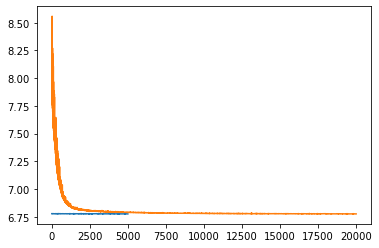

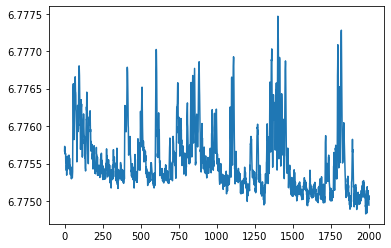

Sampling from posterior distribution...
Done.


In [7]:
adata.layers['X_corrected_cc'] = cc.run_countcorrect(counts_geneProbes, counts_negativeProbes, counts_nuclei, naive  = False)

In [10]:
total_counts = np.sum(adata.layers['X_corrected_cc'], axis = 1)
cpm = adata.layers['X_corrected_cc']/total_counts.reshape(np.shape(adata.layers['X_corrected_cc'])[0],1)*10**6
adata.layers['X_corrected_cc_cpm'] = cpm

In [11]:
adata.write_h5ad('/nfs/team283/aa16/KR_NAS/data/CR_cells_AnnData_1.h5ad')